In [26]:
# !pip3 install wandb

In [136]:
!wandb login 

wandb: Currently logged in as: cristarna21 (cristarna21-tum). Use `wandb login --relogin` to force relogin


In [211]:
import torch
import kagglehub
import wandb
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets 
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [137]:
wandb.login()

wandb: Currently logged in as: cristarna21 (cristarna21-tum). Use `wandb login --relogin` to force relogin


True

In [233]:
path = kagglehub.dataset_download("uciml/breast-cancer-wisconsin-data")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\crist\.cache\kagglehub\datasets\uciml\breast-cancer-wisconsin-data\versions\2


In [234]:
data = pd.read_csv(path + "/data.csv")

In [235]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [236]:
data.drop(["id", "Unnamed: 32"], axis=1, inplace=True)

In [237]:
data['diagnosis'] = data['diagnosis'].replace({'M': 1, 'B': 0})

C:\Users\crist\AppData\Local\Temp\ipykernel_16836\1762497399.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['diagnosis'] = data['diagnosis'].replace({'M': 1, 'B': 0})


In [238]:
Y = data['diagnosis'].to_numpy()
X = data.drop('diagnosis', axis=1)

In [239]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [240]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3)

In [241]:
class BreastCancerDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [242]:
train_dataset = BreastCancerDataset(X_train, y_train)
test_dataset = BreastCancerDataset(X_test, y_test)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)

In [243]:
for X, y in train_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([32, 30])
Shape of y:  torch.Size([32, 1]) torch.float32


In [244]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [245]:
import torch.nn as nn
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
    def __init__(self, activation_function='ReLU'):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        
        # Define activation function as a parameter
        self.activation_function = activation_function

        # Define layers
        self.linear_stack = nn.Sequential(
            nn.Linear(30, 512),
            self.get_activation_function(),
            nn.Linear(512, 512),
            self.get_activation_function(),
            nn.Linear(512, 1),
            nn.Sigmoid()  # Output layer for binary classification
        )

    def get_activation_function(self):
        """ Return the activation function based on user input """
        if self.activation_function == 'ReLU':
            return nn.ReLU()
        elif self.activation_function == 'Sigmoid':
            return nn.Sigmoid()
        elif self.activation_function == 'Tanh':
            return nn.Tanh()
        else:
            raise ValueError(f"Unsupported activation function {self.activation_function}")

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_stack(x)
        return logits  # Final predictions


In [246]:
model_relu_sig = NeuralNetwork().to(device)

In [247]:
loss_fn = nn.BCELoss()
optimizer_SDG = torch.optim.Adam(model_relu_sig.parameters(), lr=1e-3)

In [248]:
wandb.init(
    project="breast-cancer-classification",  # Replace with your project name
    config={
        "epochs": 10,
        "learning_rate": 1e-3,
        "batch_size": 32,
        "optimizer": "SGD",  # or "Adam"
        "activation": "ReLU",  # or "Sigmoid", "Tanh"
        "hidden_units": 512
    }
)

In [249]:
train_losses = []
train_accuracies = []

In [250]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    avg_loss = 0
    correct = 0
    for batch_nr, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        avg_loss += loss.item()
        correct += ((pred > 0.5) == y).type(torch.float).sum().item()
        # correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if batch_nr % 100 == 0:
            loss, current = loss.item(), batch_nr * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    avg_loss /= num_batches
    correct /= size
    # wandb.log({"train_loss": avg_loss, "train_accuracy": correct})
    return avg_loss, correct

In [251]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            # correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            correct += ((pred > 0.5) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    accuracy = 100 * correct
    # wandb.log({"test_loss": test_loss, "test_accuracy": accuracy})
    print(f"Test Error: \n Accuracy: {(accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, accuracy

Running experiment with ReLU, SGD, LR=0.001, Batch=32
loss: 0.686257  [    0/  398]
Test Error: 
 Accuracy: 72.5%, Avg loss: 0.677934 

loss: 0.676706  [    0/  398]
Test Error: 
 Accuracy: 78.9%, Avg loss: 0.669590 

loss: 0.667036  [    0/  398]
Test Error: 
 Accuracy: 81.9%, Avg loss: 0.660507 

loss: 0.655268  [    0/  398]
Test Error: 
 Accuracy: 84.2%, Avg loss: 0.653263 

loss: 0.652570  [    0/  398]
Test Error: 
 Accuracy: 86.5%, Avg loss: 0.646111 

loss: 0.657078  [    0/  398]
Test Error: 
 Accuracy: 87.7%, Avg loss: 0.640315 

loss: 0.661143  [    0/  398]
Test Error: 
 Accuracy: 88.9%, Avg loss: 0.629919 

loss: 0.622043  [    0/  398]
Test Error: 
 Accuracy: 90.1%, Avg loss: 0.624343 

loss: 0.624805  [    0/  398]
Test Error: 
 Accuracy: 90.6%, Avg loss: 0.615413 

loss: 0.619967  [    0/  398]
Test Error: 
 Accuracy: 91.2%, Avg loss: 0.610565 



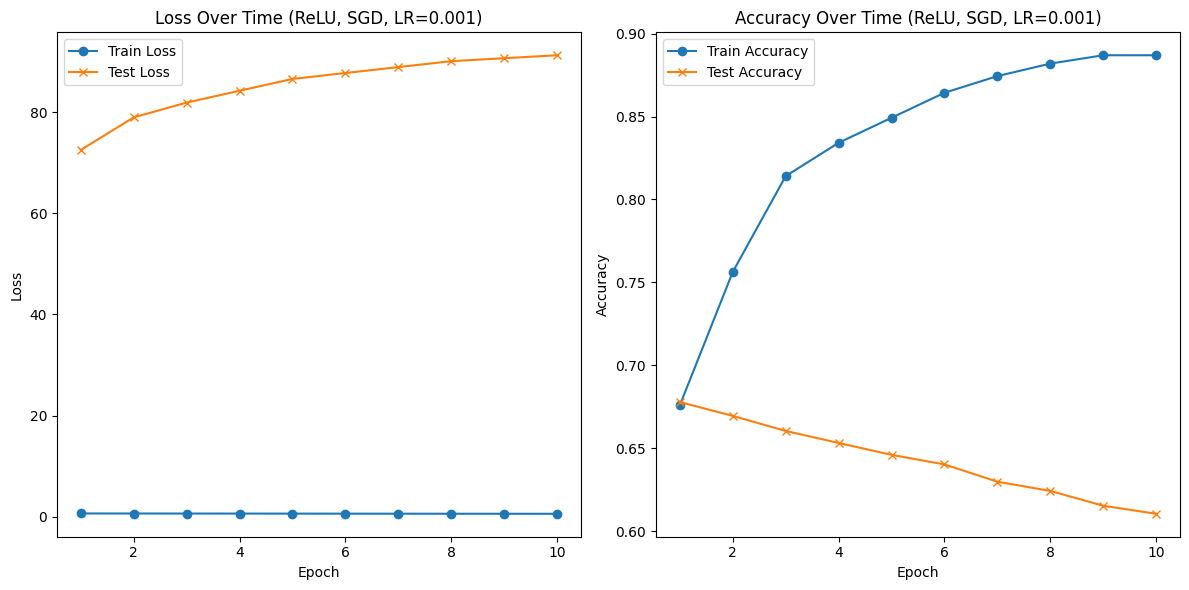

Running experiment with ReLU, SGD, LR=0.001, Batch=64
loss: 0.672959  [    0/  398]
Test Error: 
 Accuracy: 78.4%, Avg loss: 0.670805 

loss: 0.668382  [    0/  398]
Test Error: 
 Accuracy: 81.9%, Avg loss: 0.666182 

loss: 0.665131  [    0/  398]
Test Error: 
 Accuracy: 86.5%, Avg loss: 0.661558 

loss: 0.663251  [    0/  398]
Test Error: 
 Accuracy: 91.8%, Avg loss: 0.655187 

loss: 0.653262  [    0/  398]
Test Error: 
 Accuracy: 93.0%, Avg loss: 0.651477 

loss: 0.649451  [    0/  398]
Test Error: 
 Accuracy: 94.2%, Avg loss: 0.645975 

loss: 0.651080  [    0/  398]
Test Error: 
 Accuracy: 94.7%, Avg loss: 0.641164 

loss: 0.641803  [    0/  398]
Test Error: 
 Accuracy: 95.3%, Avg loss: 0.637641 

loss: 0.638037  [    0/  398]
Test Error: 
 Accuracy: 94.7%, Avg loss: 0.631412 

loss: 0.633668  [    0/  398]
Test Error: 
 Accuracy: 94.7%, Avg loss: 0.627859 



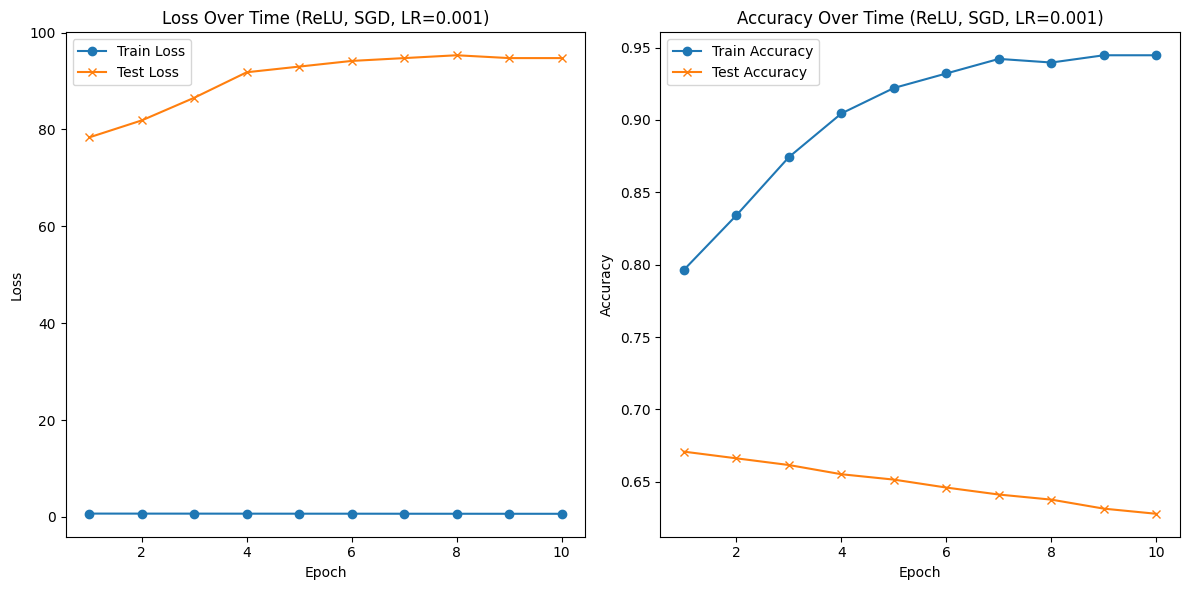

Running experiment with ReLU, SGD, LR=0.0001, Batch=32
loss: 0.708275  [    0/  398]
Test Error: 
 Accuracy: 24.0%, Avg loss: 0.719438 

loss: 0.725157  [    0/  398]
Test Error: 
 Accuracy: 24.6%, Avg loss: 0.720057 

loss: 0.722072  [    0/  398]
Test Error: 
 Accuracy: 24.6%, Avg loss: 0.717002 

loss: 0.701817  [    0/  398]
Test Error: 
 Accuracy: 25.1%, Avg loss: 0.716546 

loss: 0.710450  [    0/  398]
Test Error: 
 Accuracy: 25.1%, Avg loss: 0.715867 

loss: 0.718055  [    0/  398]
Test Error: 
 Accuracy: 25.1%, Avg loss: 0.713065 

loss: 0.715082  [    0/  398]
Test Error: 
 Accuracy: 25.1%, Avg loss: 0.713331 

loss: 0.710357  [    0/  398]
Test Error: 
 Accuracy: 25.7%, Avg loss: 0.711443 

loss: 0.711403  [    0/  398]
Test Error: 
 Accuracy: 28.1%, Avg loss: 0.711789 

loss: 0.719819  [    0/  398]
Test Error: 
 Accuracy: 30.4%, Avg loss: 0.709622 



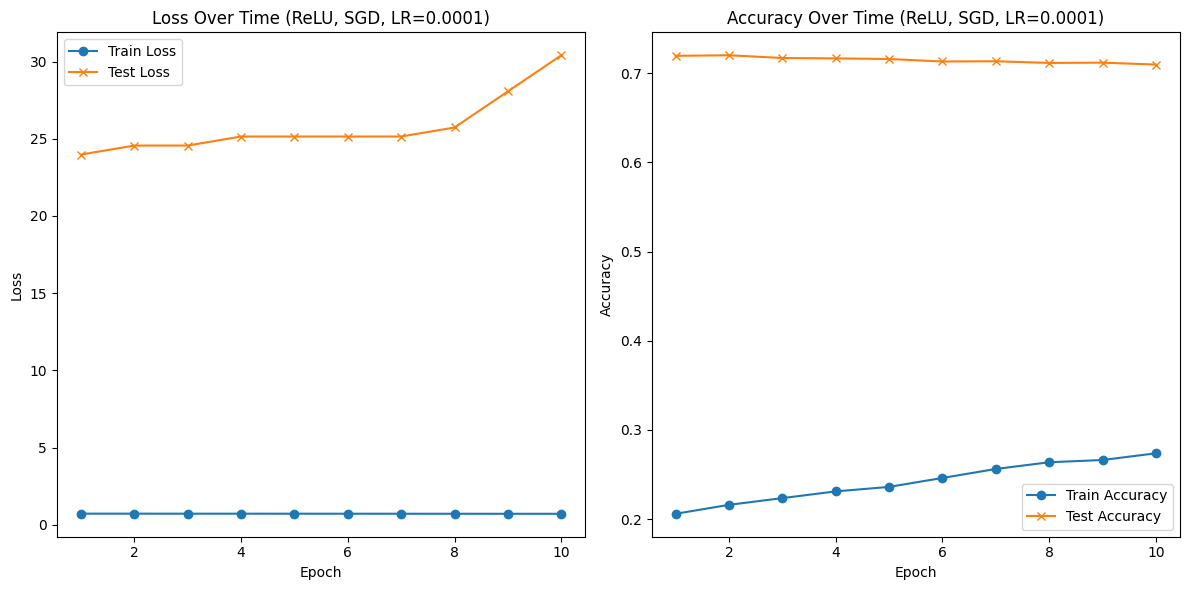

Running experiment with ReLU, SGD, LR=0.0001, Batch=64
loss: 0.699363  [    0/  398]
Test Error: 
 Accuracy: 51.5%, Avg loss: 0.694277 

loss: 0.694563  [    0/  398]
Test Error: 
 Accuracy: 52.6%, Avg loss: 0.694085 

loss: 0.686642  [    0/  398]
Test Error: 
 Accuracy: 52.6%, Avg loss: 0.693340 

loss: 0.690647  [    0/  398]
Test Error: 
 Accuracy: 52.6%, Avg loss: 0.691523 

loss: 0.688082  [    0/  398]
Test Error: 
 Accuracy: 52.6%, Avg loss: 0.690412 

loss: 0.687882  [    0/  398]
Test Error: 
 Accuracy: 53.8%, Avg loss: 0.690784 

loss: 0.689243  [    0/  398]
Test Error: 
 Accuracy: 53.8%, Avg loss: 0.690477 

loss: 0.692290  [    0/  398]
Test Error: 
 Accuracy: 53.8%, Avg loss: 0.689640 

loss: 0.689330  [    0/  398]
Test Error: 
 Accuracy: 53.8%, Avg loss: 0.689350 

loss: 0.683355  [    0/  398]
Test Error: 
 Accuracy: 54.4%, Avg loss: 0.689956 



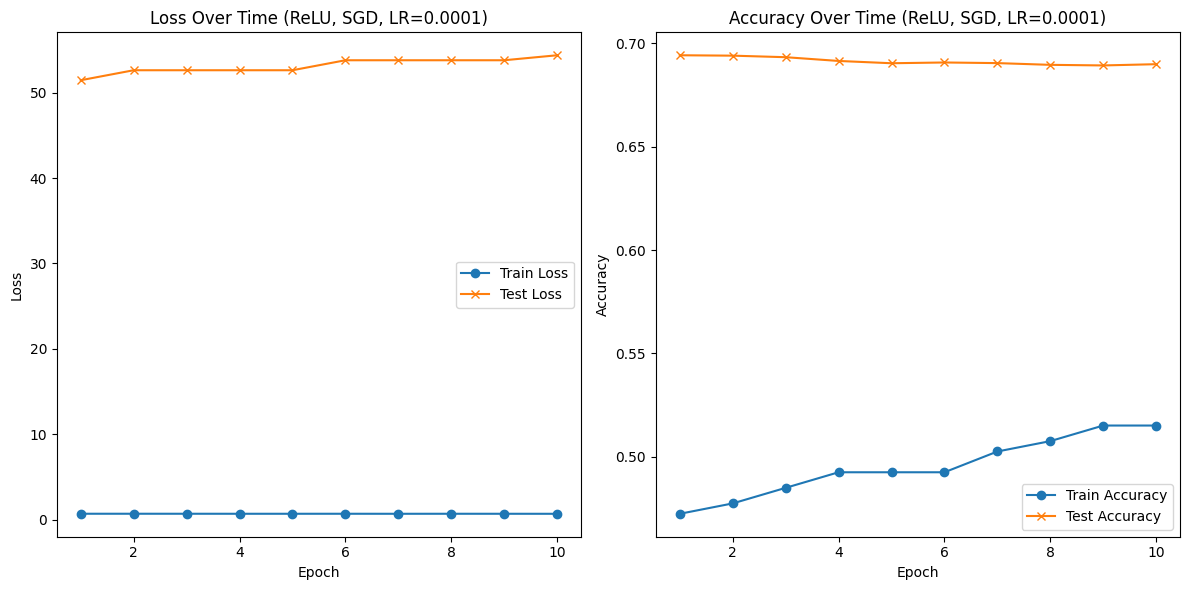

Running experiment with ReLU, Adam, LR=0.001, Batch=32
loss: 0.712643  [    0/  398]
Test Error: 
 Accuracy: 96.5%, Avg loss: 0.079577 

loss: 0.070869  [    0/  398]
Test Error: 
 Accuracy: 97.1%, Avg loss: 0.069591 

loss: 0.035175  [    0/  398]
Test Error: 
 Accuracy: 97.7%, Avg loss: 0.062057 

loss: 0.068404  [    0/  398]
Test Error: 
 Accuracy: 97.1%, Avg loss: 0.061700 

loss: 0.011696  [    0/  398]
Test Error: 
 Accuracy: 97.7%, Avg loss: 0.059036 

loss: 0.108844  [    0/  398]
Test Error: 
 Accuracy: 97.7%, Avg loss: 0.059580 

loss: 0.005628  [    0/  398]
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.066141 

loss: 0.058214  [    0/  398]
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.060999 

loss: 0.008599  [    0/  398]
Test Error: 
 Accuracy: 97.7%, Avg loss: 0.067760 

loss: 0.003120  [    0/  398]
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.064727 



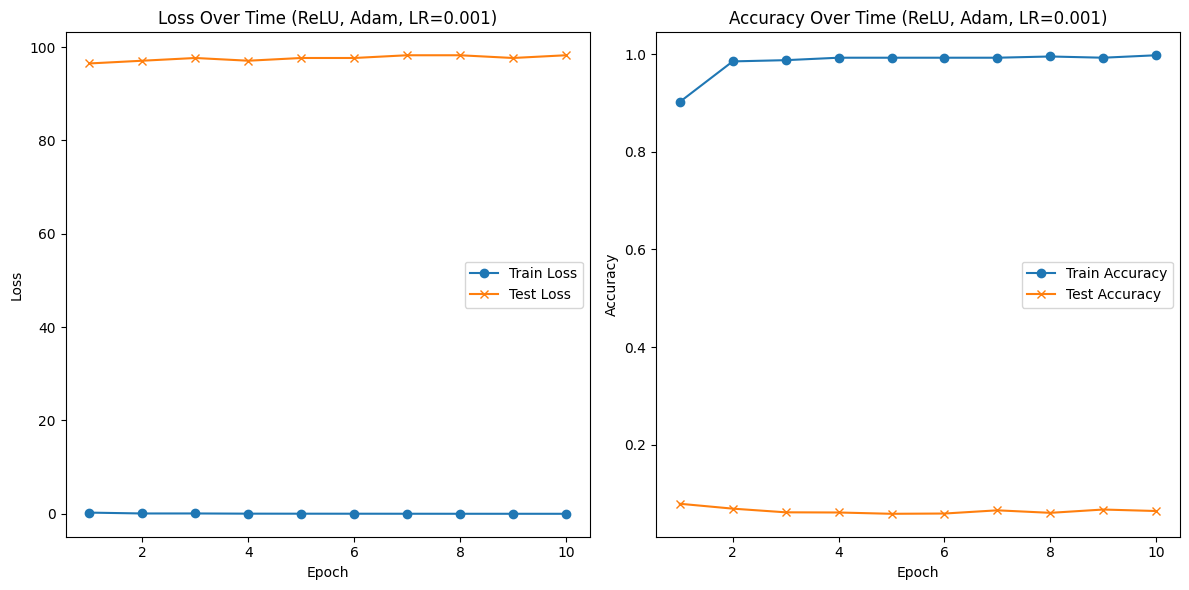

Running experiment with ReLU, Adam, LR=0.001, Batch=64
loss: 0.662427  [    0/  398]
Test Error: 
 Accuracy: 94.7%, Avg loss: 0.123695 

loss: 0.160065  [    0/  398]
Test Error: 
 Accuracy: 97.1%, Avg loss: 0.073889 

loss: 0.071244  [    0/  398]
Test Error: 
 Accuracy: 97.1%, Avg loss: 0.066127 

loss: 0.040608  [    0/  398]
Test Error: 
 Accuracy: 97.1%, Avg loss: 0.060571 

loss: 0.012657  [    0/  398]
Test Error: 
 Accuracy: 96.5%, Avg loss: 0.065511 

loss: 0.018985  [    0/  398]
Test Error: 
 Accuracy: 96.5%, Avg loss: 0.070312 

loss: 0.020004  [    0/  398]
Test Error: 
 Accuracy: 97.7%, Avg loss: 0.061316 

loss: 0.013079  [    0/  398]
Test Error: 
 Accuracy: 97.1%, Avg loss: 0.067908 

loss: 0.016643  [    0/  398]
Test Error: 
 Accuracy: 97.1%, Avg loss: 0.067505 

loss: 0.030219  [    0/  398]
Test Error: 
 Accuracy: 97.1%, Avg loss: 0.068567 



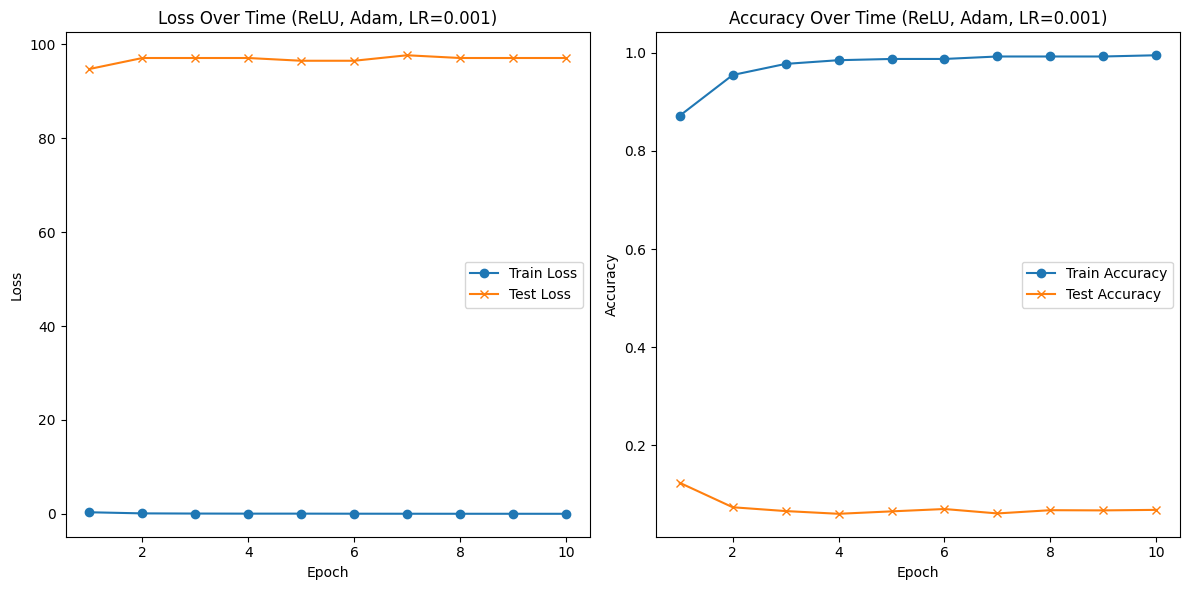

Running experiment with ReLU, Adam, LR=0.0001, Batch=32
loss: 0.700315  [    0/  398]
Test Error: 
 Accuracy: 95.3%, Avg loss: 0.504905 

loss: 0.488428  [    0/  398]
Test Error: 
 Accuracy: 95.3%, Avg loss: 0.357060 

loss: 0.387013  [    0/  398]
Test Error: 
 Accuracy: 96.5%, Avg loss: 0.272302 

loss: 0.250612  [    0/  398]
Test Error: 
 Accuracy: 95.9%, Avg loss: 0.194169 

loss: 0.170848  [    0/  398]
Test Error: 
 Accuracy: 97.1%, Avg loss: 0.159032 

loss: 0.218497  [    0/  398]
Test Error: 
 Accuracy: 96.5%, Avg loss: 0.140649 

loss: 0.178067  [    0/  398]
Test Error: 
 Accuracy: 97.1%, Avg loss: 0.124111 

loss: 0.136323  [    0/  398]
Test Error: 
 Accuracy: 97.1%, Avg loss: 0.104781 

loss: 0.106192  [    0/  398]
Test Error: 
 Accuracy: 97.7%, Avg loss: 0.100095 

loss: 0.064184  [    0/  398]
Test Error: 
 Accuracy: 97.7%, Avg loss: 0.099071 



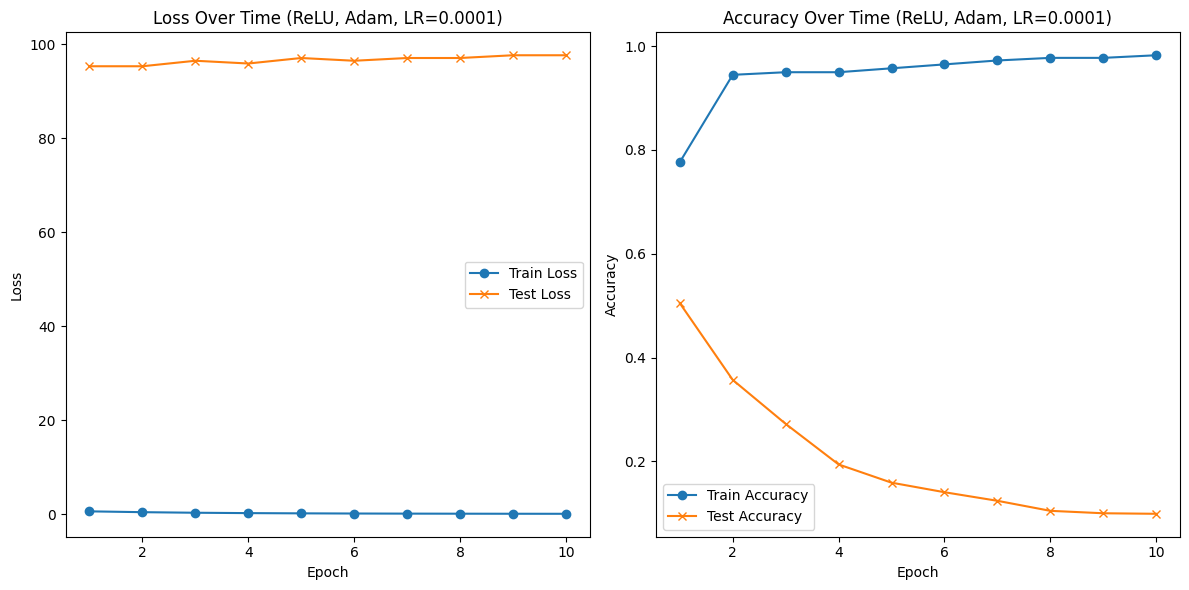

Running experiment with ReLU, Adam, LR=0.0001, Batch=64
loss: 0.671771  [    0/  398]
Test Error: 
 Accuracy: 94.7%, Avg loss: 0.546526 

loss: 0.548537  [    0/  398]
Test Error: 
 Accuracy: 96.5%, Avg loss: 0.439824 

loss: 0.436842  [    0/  398]
Test Error: 
 Accuracy: 95.3%, Avg loss: 0.363035 

loss: 0.363579  [    0/  398]
Test Error: 
 Accuracy: 95.3%, Avg loss: 0.295380 

loss: 0.268807  [    0/  398]
Test Error: 
 Accuracy: 95.3%, Avg loss: 0.250111 

loss: 0.265629  [    0/  398]
Test Error: 
 Accuracy: 95.9%, Avg loss: 0.211280 

loss: 0.229616  [    0/  398]
Test Error: 
 Accuracy: 95.9%, Avg loss: 0.175459 

loss: 0.200115  [    0/  398]
Test Error: 
 Accuracy: 95.9%, Avg loss: 0.160857 

loss: 0.155280  [    0/  398]
Test Error: 
 Accuracy: 96.5%, Avg loss: 0.140254 

loss: 0.142775  [    0/  398]
Test Error: 
 Accuracy: 96.5%, Avg loss: 0.133000 



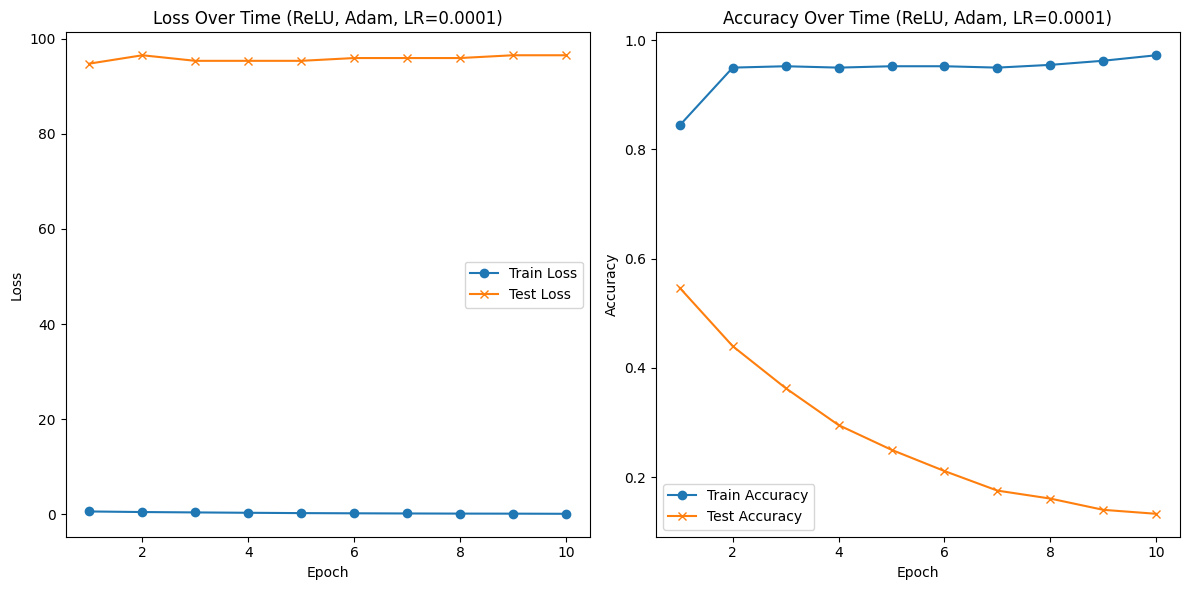

Running experiment with Sigmoid, SGD, LR=0.001, Batch=32
loss: 0.700877  [    0/  398]
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.667437 

loss: 0.640858  [    0/  398]
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.656630 

loss: 0.650192  [    0/  398]
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.654120 

loss: 0.656235  [    0/  398]
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.642037 

loss: 0.654240  [    0/  398]
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.647208 

loss: 0.664665  [    0/  398]
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.645453 

loss: 0.702356  [    0/  398]
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.643468 

loss: 0.690685  [    0/  398]
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.637918 

loss: 0.689183  [    0/  398]
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.646018 

loss: 0.603205  [    0/  398]
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.646904 



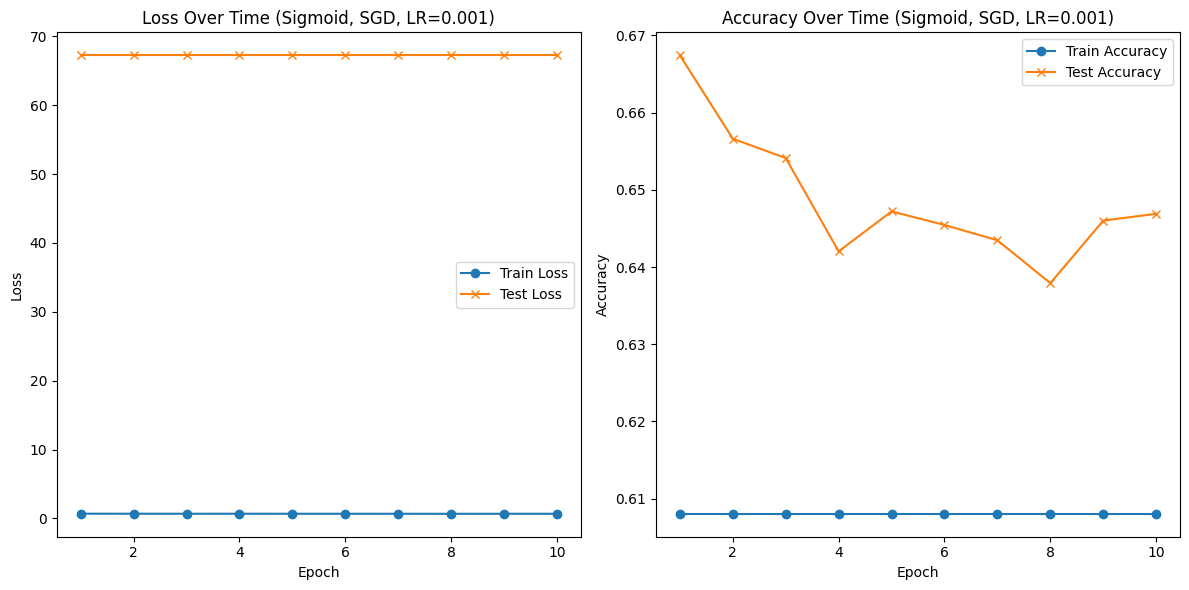

Running experiment with Sigmoid, SGD, LR=0.001, Batch=64
loss: 0.707784  [    0/  398]
Test Error: 
 Accuracy: 32.7%, Avg loss: 0.707323 

loss: 0.701520  [    0/  398]
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.690694 

loss: 0.691725  [    0/  398]
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.681837 

loss: 0.687457  [    0/  398]
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.670067 

loss: 0.666274  [    0/  398]
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.663743 

loss: 0.657814  [    0/  398]
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.656292 

loss: 0.670123  [    0/  398]
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.651770 

loss: 0.659260  [    0/  398]
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.654810 

loss: 0.697380  [    0/  398]
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.651414 

loss: 0.660637  [    0/  398]
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.647084 



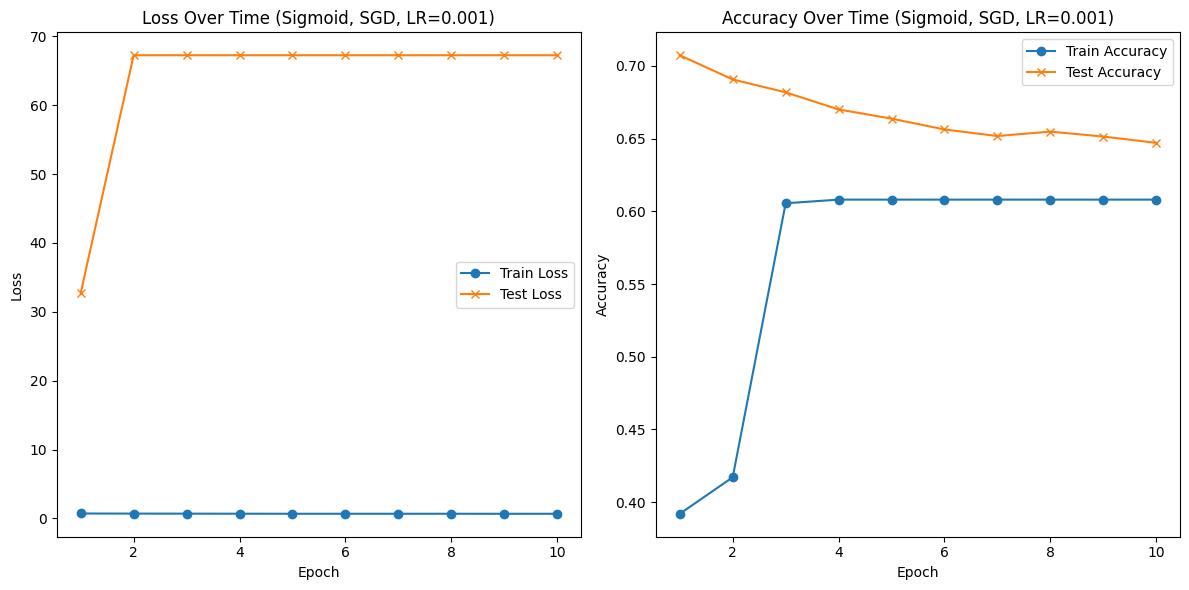

Running experiment with Sigmoid, SGD, LR=0.0001, Batch=32
loss: 0.687312  [    0/  398]
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.677920 

loss: 0.677109  [    0/  398]
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.675114 

loss: 0.692521  [    0/  398]
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.673735 

loss: 0.683295  [    0/  398]
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.669376 

loss: 0.681990  [    0/  398]
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.665530 

loss: 0.678051  [    0/  398]
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.667369 

loss: 0.691523  [    0/  398]
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.670852 

loss: 0.675089  [    0/  398]
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.663986 

loss: 0.665265  [    0/  398]
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.663026 

loss: 0.697804  [    0/  398]
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.669583 



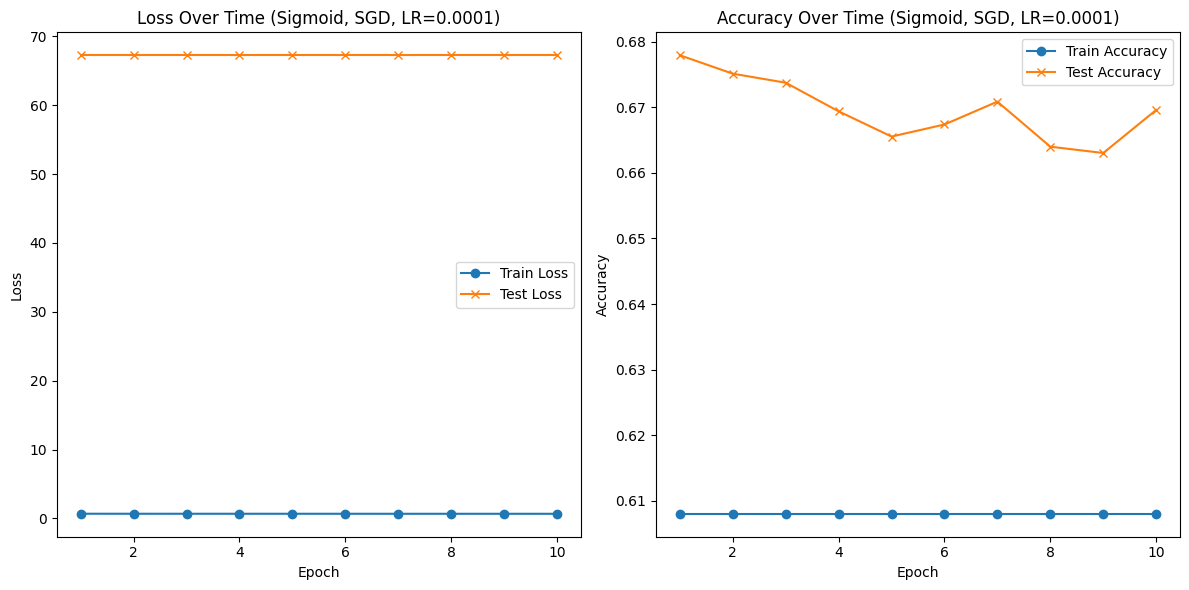

Running experiment with Sigmoid, SGD, LR=0.0001, Batch=64
loss: 0.708954  [    0/  398]
Test Error: 
 Accuracy: 32.7%, Avg loss: 0.719993 

loss: 0.715451  [    0/  398]
Test Error: 
 Accuracy: 32.7%, Avg loss: 0.718604 

loss: 0.714155  [    0/  398]
Test Error: 
 Accuracy: 32.7%, Avg loss: 0.715972 

loss: 0.725713  [    0/  398]
Test Error: 
 Accuracy: 32.7%, Avg loss: 0.713123 

loss: 0.716499  [    0/  398]
Test Error: 
 Accuracy: 32.7%, Avg loss: 0.709742 

loss: 0.702891  [    0/  398]
Test Error: 
 Accuracy: 32.7%, Avg loss: 0.708888 

loss: 0.704874  [    0/  398]
Test Error: 
 Accuracy: 32.7%, Avg loss: 0.706067 

loss: 0.700181  [    0/  398]
Test Error: 
 Accuracy: 32.7%, Avg loss: 0.704567 

loss: 0.695231  [    0/  398]
Test Error: 
 Accuracy: 32.2%, Avg loss: 0.702541 

loss: 0.702458  [    0/  398]
Test Error: 
 Accuracy: 32.2%, Avg loss: 0.700133 



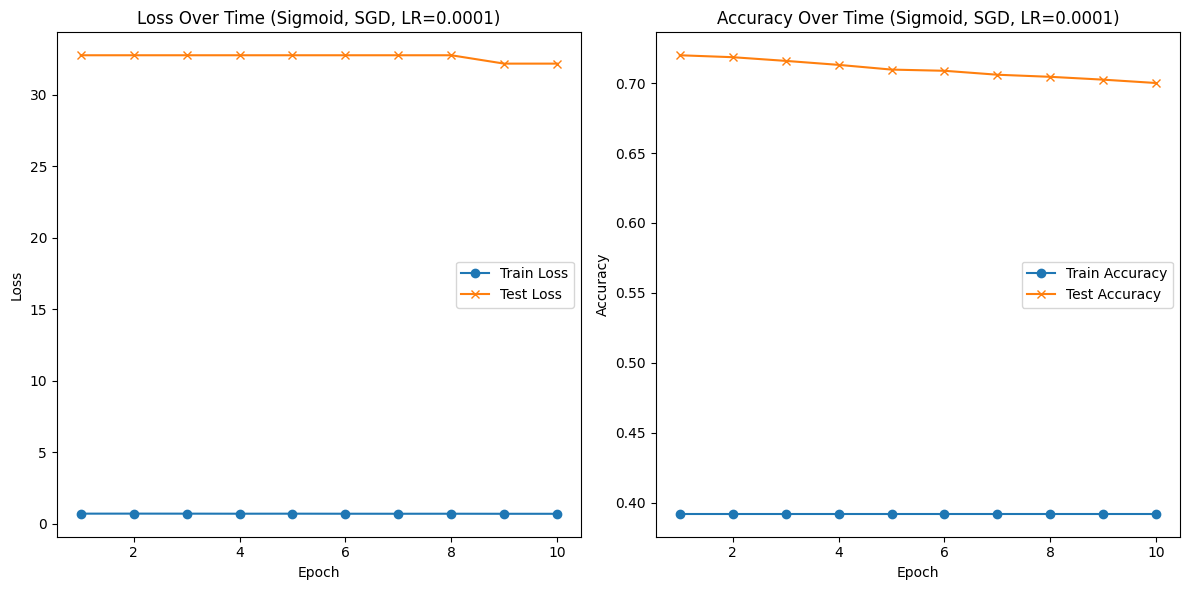

Running experiment with Sigmoid, Adam, LR=0.001, Batch=32
loss: 0.686211  [    0/  398]
Test Error: 
 Accuracy: 89.5%, Avg loss: 0.488218 

loss: 0.493144  [    0/  398]
Test Error: 
 Accuracy: 93.0%, Avg loss: 0.275149 

loss: 0.243603  [    0/  398]
Test Error: 
 Accuracy: 94.2%, Avg loss: 0.159957 

loss: 0.202312  [    0/  398]
Test Error: 
 Accuracy: 95.9%, Avg loss: 0.126414 

loss: 0.272645  [    0/  398]
Test Error: 
 Accuracy: 95.9%, Avg loss: 0.089675 

loss: 0.204042  [    0/  398]
Test Error: 
 Accuracy: 97.1%, Avg loss: 0.084421 

loss: 0.056228  [    0/  398]
Test Error: 
 Accuracy: 97.7%, Avg loss: 0.101187 

loss: 0.065917  [    0/  398]
Test Error: 
 Accuracy: 97.1%, Avg loss: 0.080977 

loss: 0.041441  [    0/  398]
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.072345 

loss: 0.020370  [    0/  398]
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.066184 



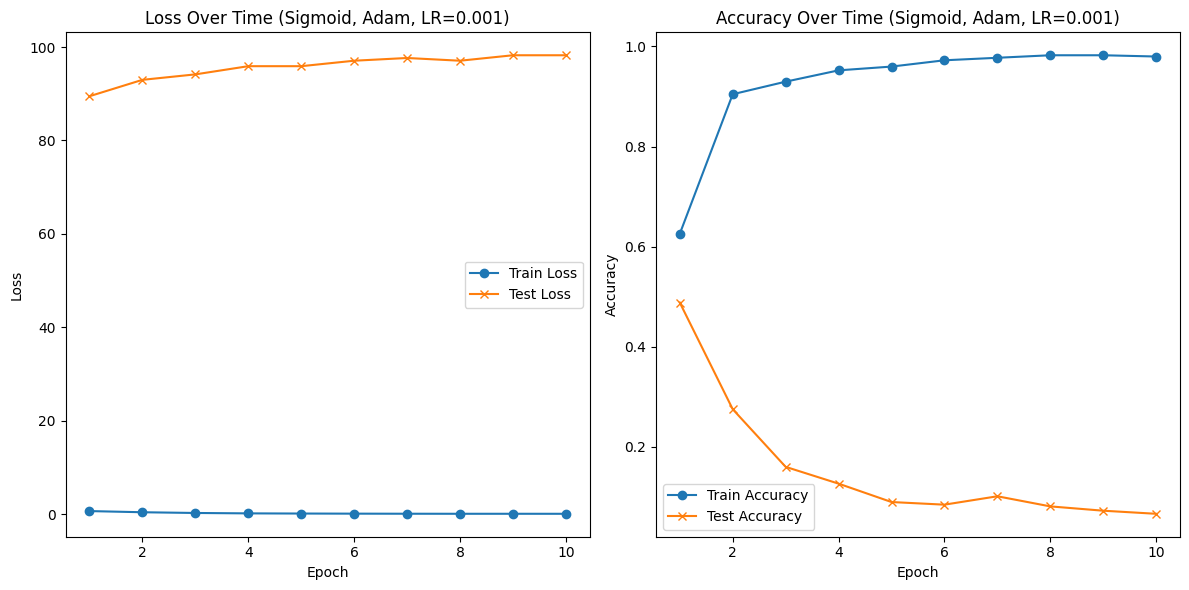

Running experiment with Sigmoid, Adam, LR=0.001, Batch=64
loss: 0.684010  [    0/  398]
Test Error: 
 Accuracy: 90.1%, Avg loss: 0.479233 

loss: 0.499522  [    0/  398]
Test Error: 
 Accuracy: 92.4%, Avg loss: 0.284618 

loss: 0.322874  [    0/  398]
Test Error: 
 Accuracy: 93.6%, Avg loss: 0.185984 

loss: 0.213509  [    0/  398]
Test Error: 
 Accuracy: 94.2%, Avg loss: 0.128903 

loss: 0.106502  [    0/  398]
Test Error: 
 Accuracy: 95.3%, Avg loss: 0.103465 

loss: 0.158591  [    0/  398]
Test Error: 
 Accuracy: 97.1%, Avg loss: 0.088222 

loss: 0.053473  [    0/  398]
Test Error: 
 Accuracy: 96.5%, Avg loss: 0.087666 

loss: 0.073930  [    0/  398]
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.071666 

loss: 0.070685  [    0/  398]
Test Error: 
 Accuracy: 97.7%, Avg loss: 0.074893 

loss: 0.061357  [    0/  398]
Test Error: 
 Accuracy: 97.7%, Avg loss: 0.069653 



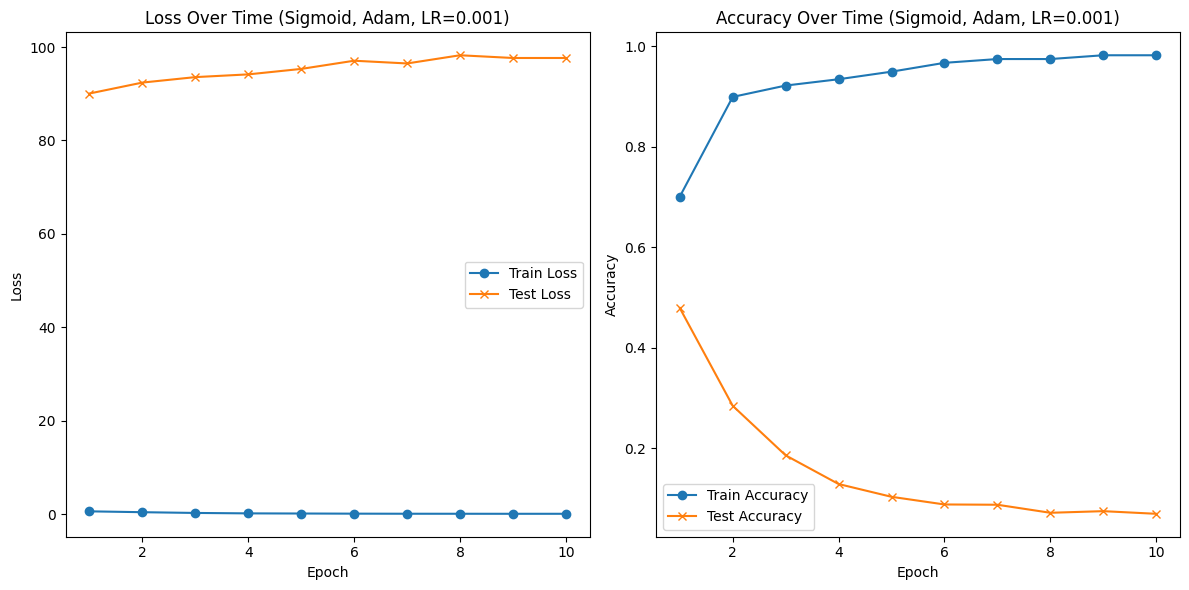

Running experiment with Sigmoid, Adam, LR=0.0001, Batch=32
loss: 0.684401  [    0/  398]
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.608967 

loss: 0.652122  [    0/  398]
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.598396 

loss: 0.685841  [    0/  398]
Test Error: 
 Accuracy: 72.5%, Avg loss: 0.570789 

loss: 0.537108  [    0/  398]
Test Error: 
 Accuracy: 77.2%, Avg loss: 0.535830 

loss: 0.576360  [    0/  398]
Test Error: 
 Accuracy: 84.8%, Avg loss: 0.503593 

loss: 0.561088  [    0/  398]
Test Error: 
 Accuracy: 87.7%, Avg loss: 0.474857 

loss: 0.504045  [    0/  398]
Test Error: 
 Accuracy: 86.5%, Avg loss: 0.432666 

loss: 0.497382  [    0/  398]
Test Error: 
 Accuracy: 90.6%, Avg loss: 0.394562 

loss: 0.399349  [    0/  398]
Test Error: 
 Accuracy: 92.4%, Avg loss: 0.373206 

loss: 0.356516  [    0/  398]
Test Error: 
 Accuracy: 94.2%, Avg loss: 0.346187 



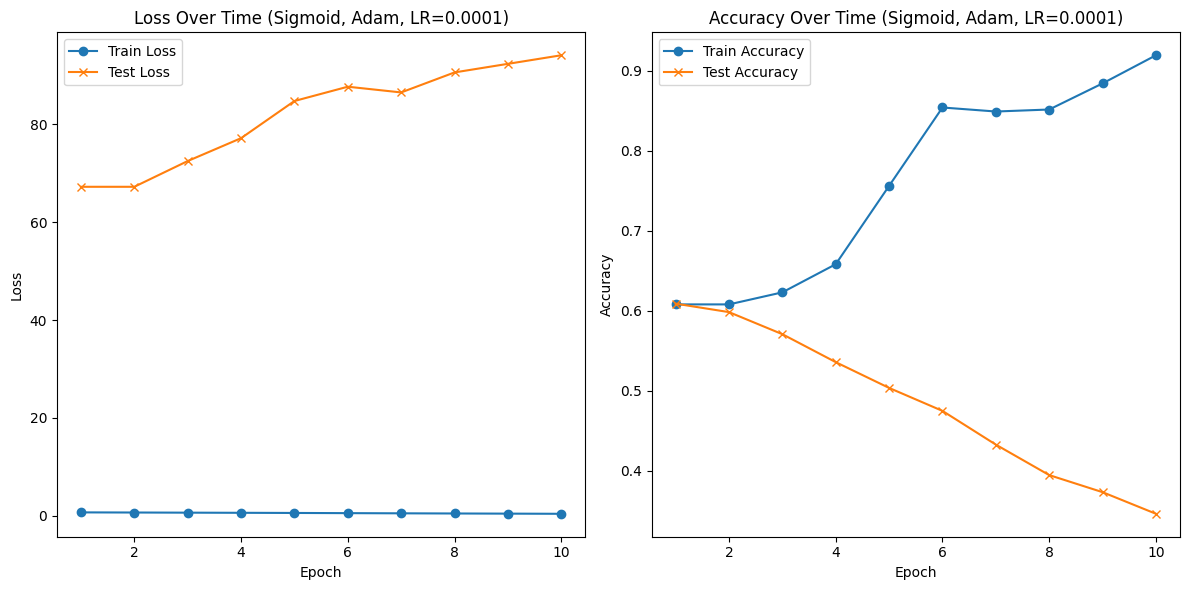

Running experiment with Sigmoid, Adam, LR=0.0001, Batch=64
loss: 0.707517  [    0/  398]
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.637311 

loss: 0.667415  [    0/  398]
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.615774 

loss: 0.687273  [    0/  398]
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.599902 

loss: 0.608479  [    0/  398]
Test Error: 
 Accuracy: 67.8%, Avg loss: 0.580868 

loss: 0.632685  [    0/  398]
Test Error: 
 Accuracy: 70.8%, Avg loss: 0.564874 

loss: 0.605906  [    0/  398]
Test Error: 
 Accuracy: 73.1%, Avg loss: 0.538378 

loss: 0.565299  [    0/  398]
Test Error: 
 Accuracy: 77.8%, Avg loss: 0.524651 

loss: 0.530930  [    0/  398]
Test Error: 
 Accuracy: 83.0%, Avg loss: 0.498470 

loss: 0.532283  [    0/  398]
Test Error: 
 Accuracy: 86.0%, Avg loss: 0.483238 

loss: 0.511787  [    0/  398]
Test Error: 
 Accuracy: 88.9%, Avg loss: 0.463191 



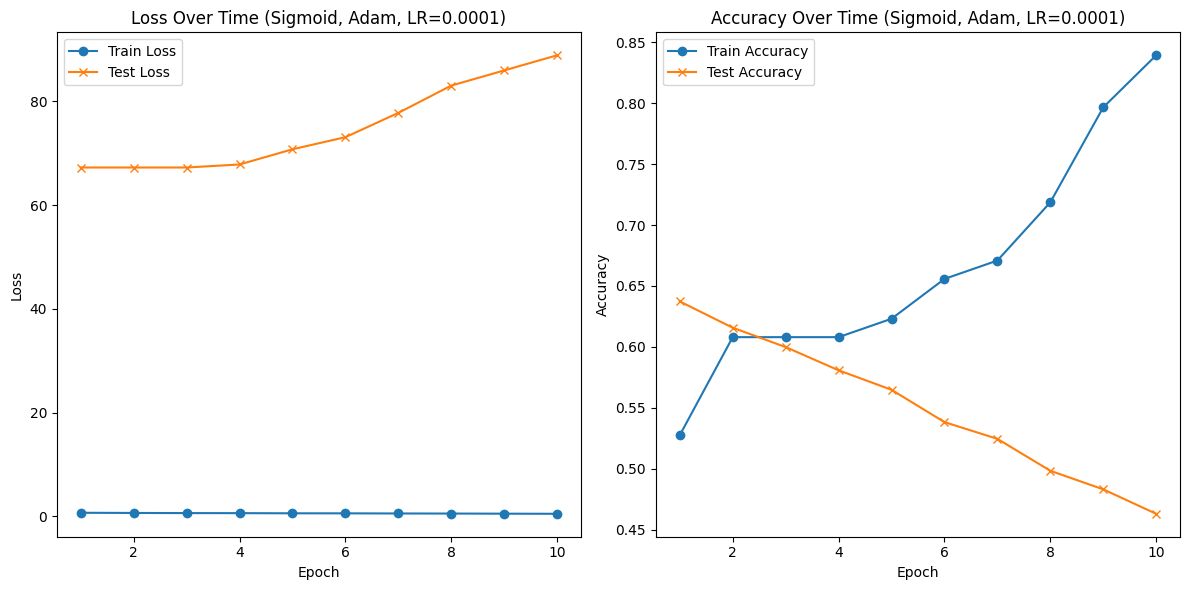

Running experiment with Tanh, SGD, LR=0.001, Batch=32
loss: 0.653964  [    0/  398]
Test Error: 
 Accuracy: 87.1%, Avg loss: 0.599012 

loss: 0.597984  [    0/  398]
Test Error: 
 Accuracy: 91.8%, Avg loss: 0.563374 

loss: 0.583357  [    0/  398]
Test Error: 
 Accuracy: 91.2%, Avg loss: 0.523669 

loss: 0.515810  [    0/  398]
Test Error: 
 Accuracy: 92.4%, Avg loss: 0.494644 

loss: 0.465431  [    0/  398]
Test Error: 
 Accuracy: 93.0%, Avg loss: 0.477546 

loss: 0.481412  [    0/  398]
Test Error: 
 Accuracy: 93.6%, Avg loss: 0.448845 

loss: 0.417656  [    0/  398]
Test Error: 
 Accuracy: 94.2%, Avg loss: 0.427103 

loss: 0.436345  [    0/  398]
Test Error: 
 Accuracy: 94.2%, Avg loss: 0.408007 

loss: 0.393557  [    0/  398]
Test Error: 
 Accuracy: 93.6%, Avg loss: 0.394129 

loss: 0.406398  [    0/  398]
Test Error: 
 Accuracy: 93.6%, Avg loss: 0.386997 



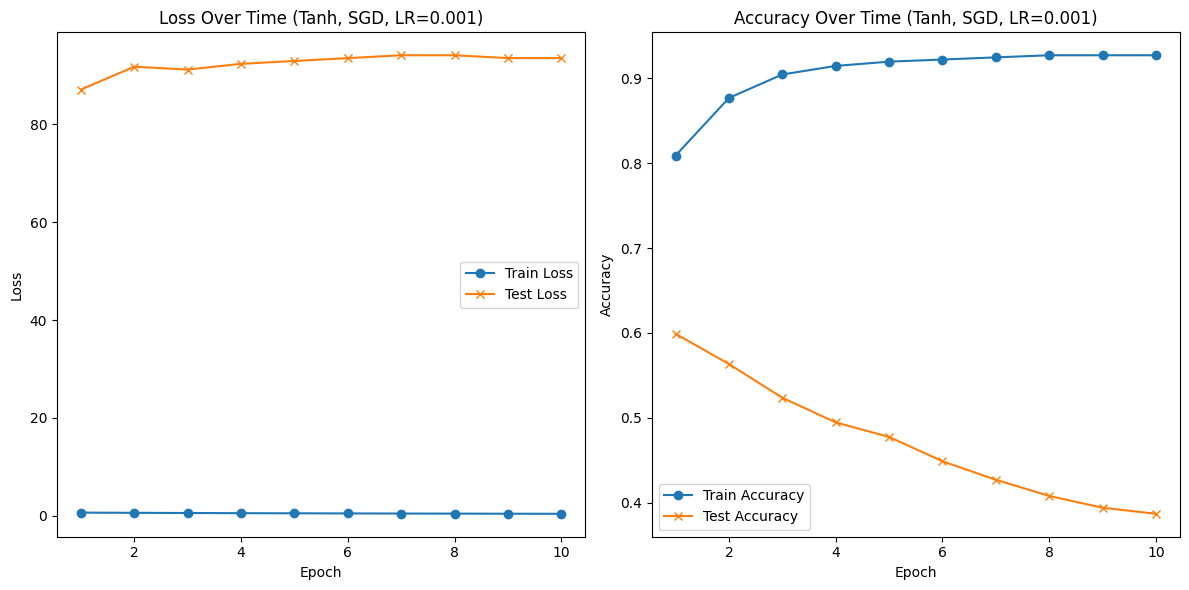

Running experiment with Tanh, SGD, LR=0.001, Batch=64
loss: 0.732046  [    0/  398]
Test Error: 
 Accuracy: 56.7%, Avg loss: 0.694119 

loss: 0.695576  [    0/  398]
Test Error: 
 Accuracy: 77.2%, Avg loss: 0.665722 

loss: 0.666611  [    0/  398]
Test Error: 
 Accuracy: 85.4%, Avg loss: 0.637621 

loss: 0.647735  [    0/  398]
Test Error: 
 Accuracy: 88.9%, Avg loss: 0.612645 

loss: 0.618495  [    0/  398]
Test Error: 
 Accuracy: 93.0%, Avg loss: 0.592525 

loss: 0.593896  [    0/  398]
Test Error: 
 Accuracy: 93.0%, Avg loss: 0.568262 

loss: 0.580498  [    0/  398]
Test Error: 
 Accuracy: 94.2%, Avg loss: 0.547194 

loss: 0.560036  [    0/  398]
Test Error: 
 Accuracy: 94.2%, Avg loss: 0.530368 

loss: 0.521253  [    0/  398]
Test Error: 
 Accuracy: 94.2%, Avg loss: 0.513369 

loss: 0.511809  [    0/  398]
Test Error: 
 Accuracy: 94.7%, Avg loss: 0.495960 



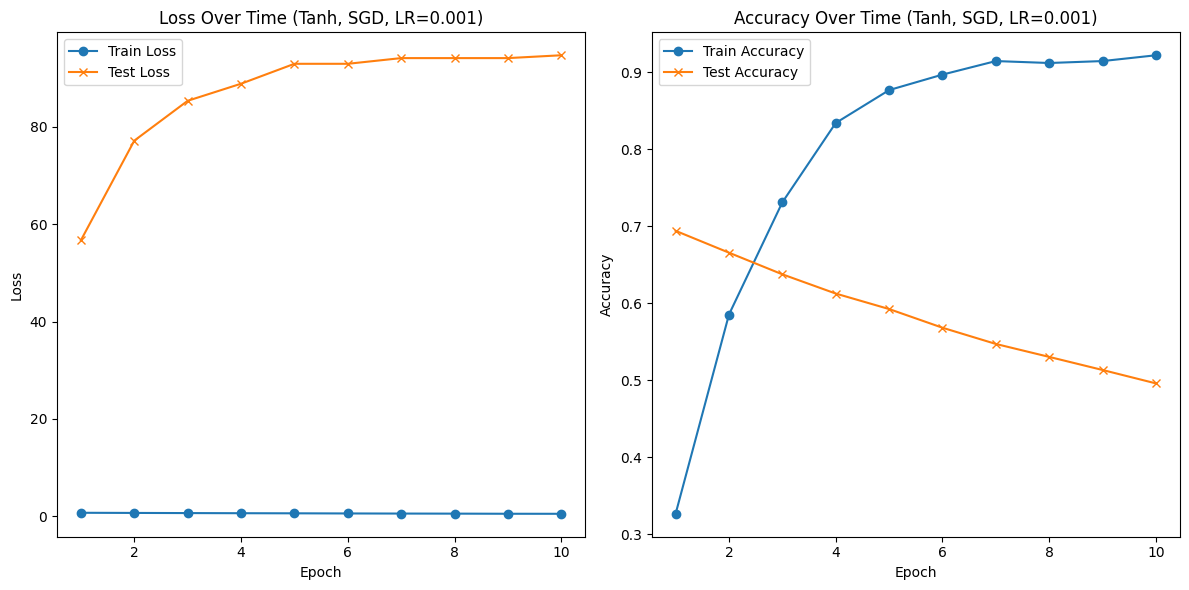

Running experiment with Tanh, SGD, LR=0.0001, Batch=32
loss: 0.696011  [    0/  398]
Test Error: 
 Accuracy: 57.3%, Avg loss: 0.688431 

loss: 0.684506  [    0/  398]
Test Error: 
 Accuracy: 63.7%, Avg loss: 0.682449 

loss: 0.689140  [    0/  398]
Test Error: 
 Accuracy: 69.0%, Avg loss: 0.677959 

loss: 0.674324  [    0/  398]
Test Error: 
 Accuracy: 74.9%, Avg loss: 0.671377 

loss: 0.656124  [    0/  398]
Test Error: 
 Accuracy: 80.1%, Avg loss: 0.669582 

loss: 0.663987  [    0/  398]
Test Error: 
 Accuracy: 81.9%, Avg loss: 0.661057 

loss: 0.662652  [    0/  398]
Test Error: 
 Accuracy: 86.5%, Avg loss: 0.656412 

loss: 0.659034  [    0/  398]
Test Error: 
 Accuracy: 87.1%, Avg loss: 0.649575 

loss: 0.649931  [    0/  398]
Test Error: 
 Accuracy: 88.9%, Avg loss: 0.642542 

loss: 0.628653  [    0/  398]
Test Error: 
 Accuracy: 89.5%, Avg loss: 0.637964 



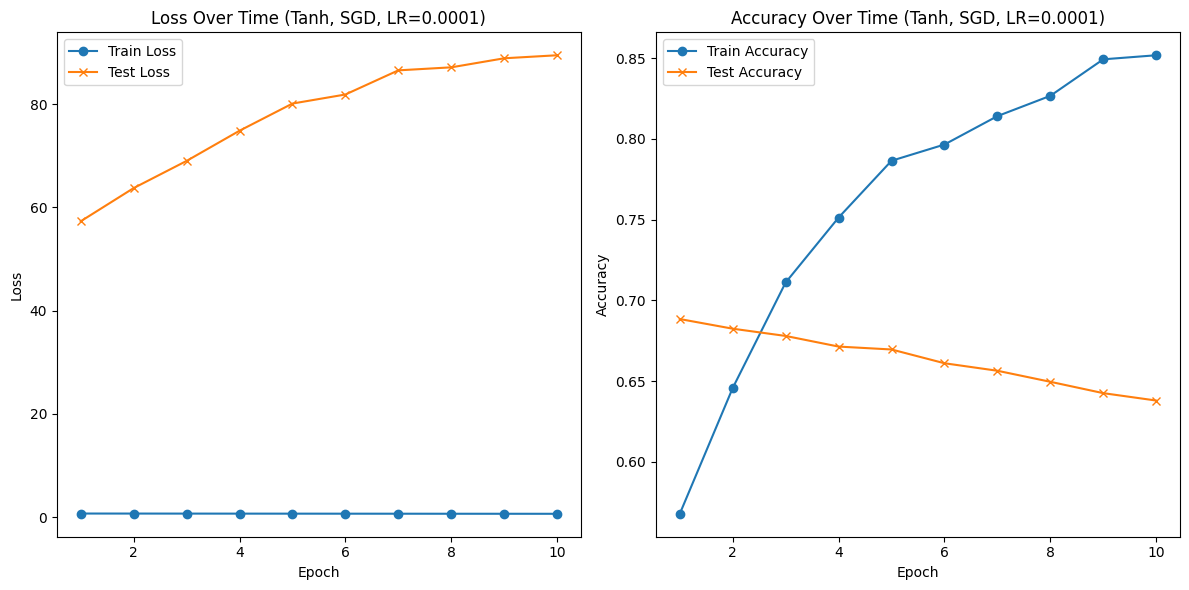

Running experiment with Tanh, SGD, LR=0.0001, Batch=64
loss: 0.718961  [    0/  398]
Test Error: 
 Accuracy: 21.6%, Avg loss: 0.719794 

loss: 0.727428  [    0/  398]
Test Error: 
 Accuracy: 23.4%, Avg loss: 0.717632 

loss: 0.710320  [    0/  398]
Test Error: 
 Accuracy: 27.5%, Avg loss: 0.715078 

loss: 0.711092  [    0/  398]
Test Error: 
 Accuracy: 31.6%, Avg loss: 0.713062 

loss: 0.703187  [    0/  398]
Test Error: 
 Accuracy: 35.1%, Avg loss: 0.708748 

loss: 0.703768  [    0/  398]
Test Error: 
 Accuracy: 37.4%, Avg loss: 0.706229 

loss: 0.708739  [    0/  398]
Test Error: 
 Accuracy: 40.4%, Avg loss: 0.703807 

loss: 0.693659  [    0/  398]
Test Error: 
 Accuracy: 42.7%, Avg loss: 0.699543 

loss: 0.699476  [    0/  398]
Test Error: 
 Accuracy: 45.6%, Avg loss: 0.697243 

loss: 0.689707  [    0/  398]
Test Error: 
 Accuracy: 47.4%, Avg loss: 0.695096 



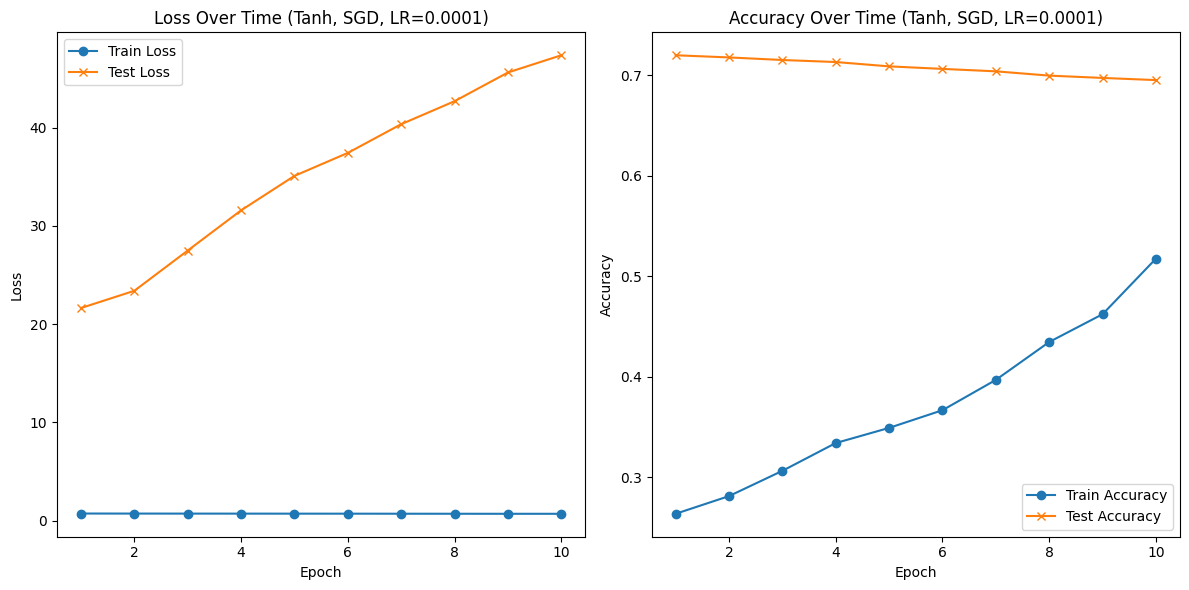

Running experiment with Tanh, Adam, LR=0.001, Batch=32
loss: 0.704176  [    0/  398]
Test Error: 
 Accuracy: 96.5%, Avg loss: 0.064342 

loss: 0.042060  [    0/  398]
Test Error: 
 Accuracy: 96.5%, Avg loss: 0.081427 

loss: 0.032246  [    0/  398]
Test Error: 
 Accuracy: 95.3%, Avg loss: 0.079091 

loss: 0.015083  [    0/  398]
Test Error: 
 Accuracy: 97.1%, Avg loss: 0.070682 

loss: 0.007719  [    0/  398]
Test Error: 
 Accuracy: 97.1%, Avg loss: 0.071586 

loss: 0.065701  [    0/  398]
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.071487 

loss: 0.023240  [    0/  398]
Test Error: 
 Accuracy: 96.5%, Avg loss: 0.069830 

loss: 0.015115  [    0/  398]
Test Error: 
 Accuracy: 96.5%, Avg loss: 0.080298 

loss: 0.011099  [    0/  398]
Test Error: 
 Accuracy: 97.1%, Avg loss: 0.072988 

loss: 0.024349  [    0/  398]
Test Error: 
 Accuracy: 96.5%, Avg loss: 0.068957 



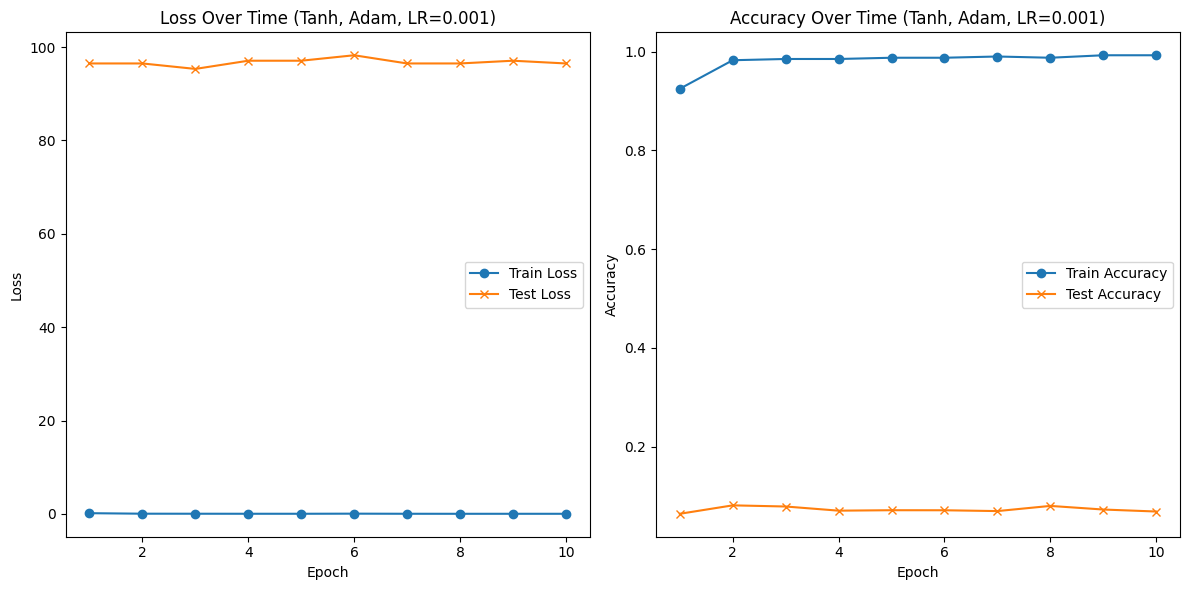

Running experiment with Tanh, Adam, LR=0.001, Batch=64
loss: 0.682244  [    0/  398]
Test Error: 
 Accuracy: 95.3%, Avg loss: 0.089366 

loss: 0.086943  [    0/  398]
Test Error: 
 Accuracy: 97.1%, Avg loss: 0.071366 

loss: 0.087624  [    0/  398]
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.056763 

loss: 0.144212  [    0/  398]
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.057939 

loss: 0.133502  [    0/  398]
Test Error: 
 Accuracy: 96.5%, Avg loss: 0.079449 

loss: 0.058243  [    0/  398]
Test Error: 
 Accuracy: 95.9%, Avg loss: 0.080833 

loss: 0.158455  [    0/  398]
Test Error: 
 Accuracy: 96.5%, Avg loss: 0.076240 

loss: 0.055093  [    0/  398]
Test Error: 
 Accuracy: 97.1%, Avg loss: 0.069346 

loss: 0.053678  [    0/  398]
Test Error: 
 Accuracy: 95.3%, Avg loss: 0.078040 

loss: 0.019208  [    0/  398]
Test Error: 
 Accuracy: 97.1%, Avg loss: 0.084620 



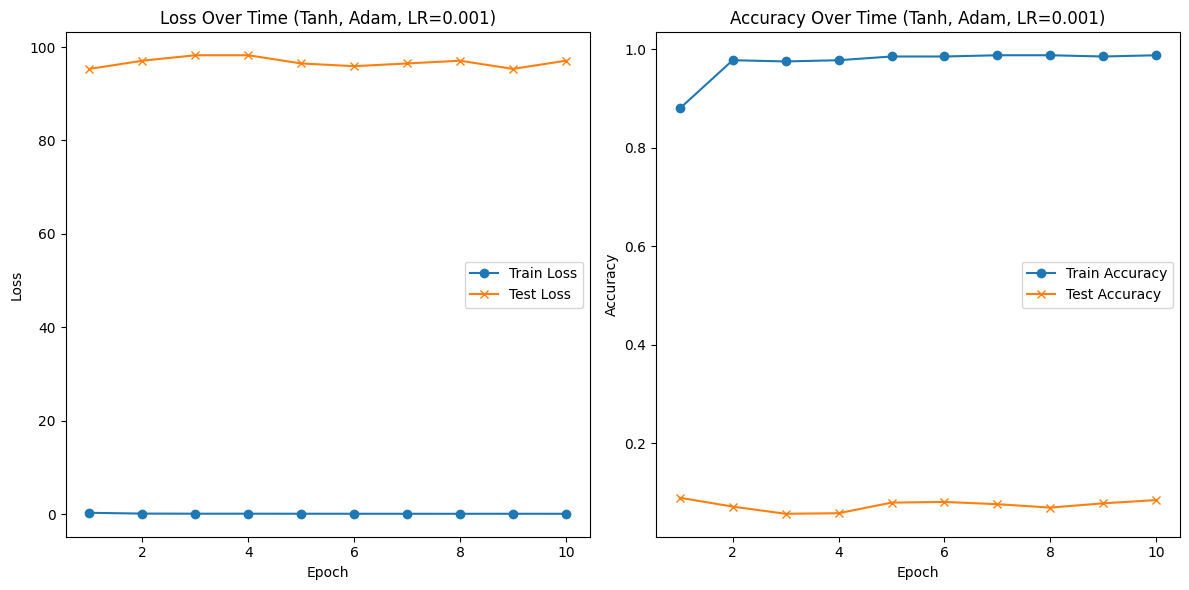

Running experiment with Tanh, Adam, LR=0.0001, Batch=32
loss: 0.700064  [    0/  398]
Test Error: 
 Accuracy: 93.0%, Avg loss: 0.291273 

loss: 0.223329  [    0/  398]
Test Error: 
 Accuracy: 94.7%, Avg loss: 0.185567 

loss: 0.140369  [    0/  398]
Test Error: 
 Accuracy: 95.9%, Avg loss: 0.134746 

loss: 0.109136  [    0/  398]
Test Error: 
 Accuracy: 96.5%, Avg loss: 0.117055 

loss: 0.151034  [    0/  398]
Test Error: 
 Accuracy: 96.5%, Avg loss: 0.102066 

loss: 0.120658  [    0/  398]
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.114237 

loss: 0.095253  [    0/  398]
Test Error: 
 Accuracy: 97.7%, Avg loss: 0.083055 

loss: 0.059408  [    0/  398]
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.083332 

loss: 0.106353  [    0/  398]
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.090965 

loss: 0.037859  [    0/  398]
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.097860 



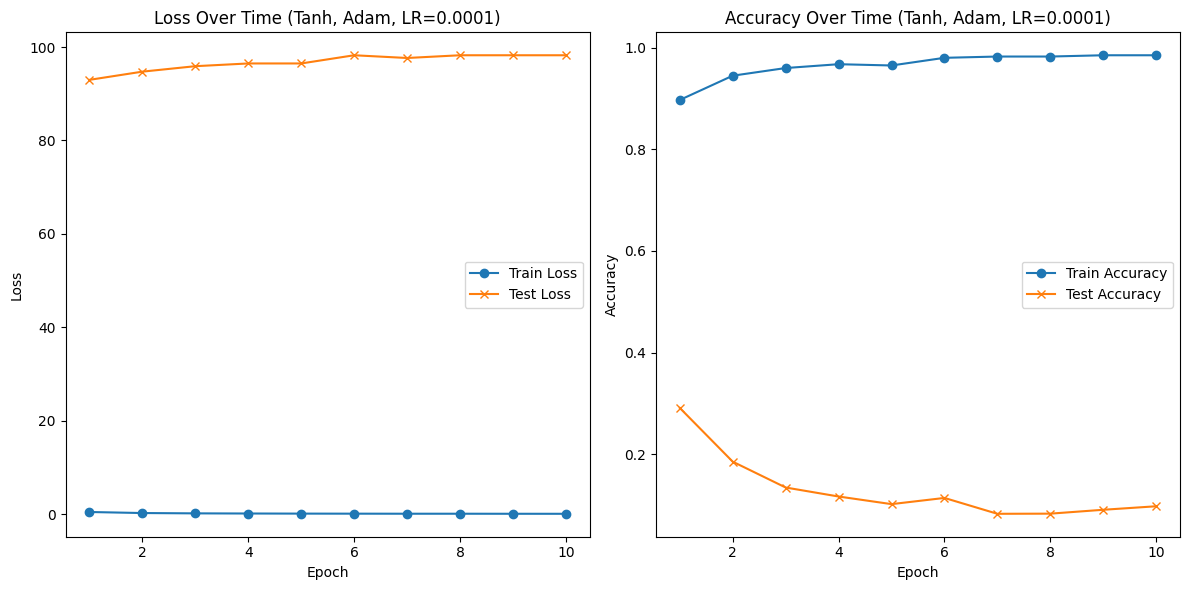

Running experiment with Tanh, Adam, LR=0.0001, Batch=64
loss: 0.704365  [    0/  398]
Test Error: 
 Accuracy: 94.7%, Avg loss: 0.397752 

loss: 0.385588  [    0/  398]
Test Error: 
 Accuracy: 95.3%, Avg loss: 0.270715 

loss: 0.231633  [    0/  398]
Test Error: 
 Accuracy: 95.3%, Avg loss: 0.196398 

loss: 0.218639  [    0/  398]
Test Error: 
 Accuracy: 95.3%, Avg loss: 0.157383 

loss: 0.215656  [    0/  398]
Test Error: 
 Accuracy: 95.9%, Avg loss: 0.141589 

loss: 0.147838  [    0/  398]
Test Error: 
 Accuracy: 95.9%, Avg loss: 0.125902 

loss: 0.119421  [    0/  398]
Test Error: 
 Accuracy: 95.9%, Avg loss: 0.111298 

loss: 0.173122  [    0/  398]
Test Error: 
 Accuracy: 96.5%, Avg loss: 0.104339 

loss: 0.101950  [    0/  398]
Test Error: 
 Accuracy: 97.1%, Avg loss: 0.099095 

loss: 0.063142  [    0/  398]
Test Error: 
 Accuracy: 97.1%, Avg loss: 0.096743 



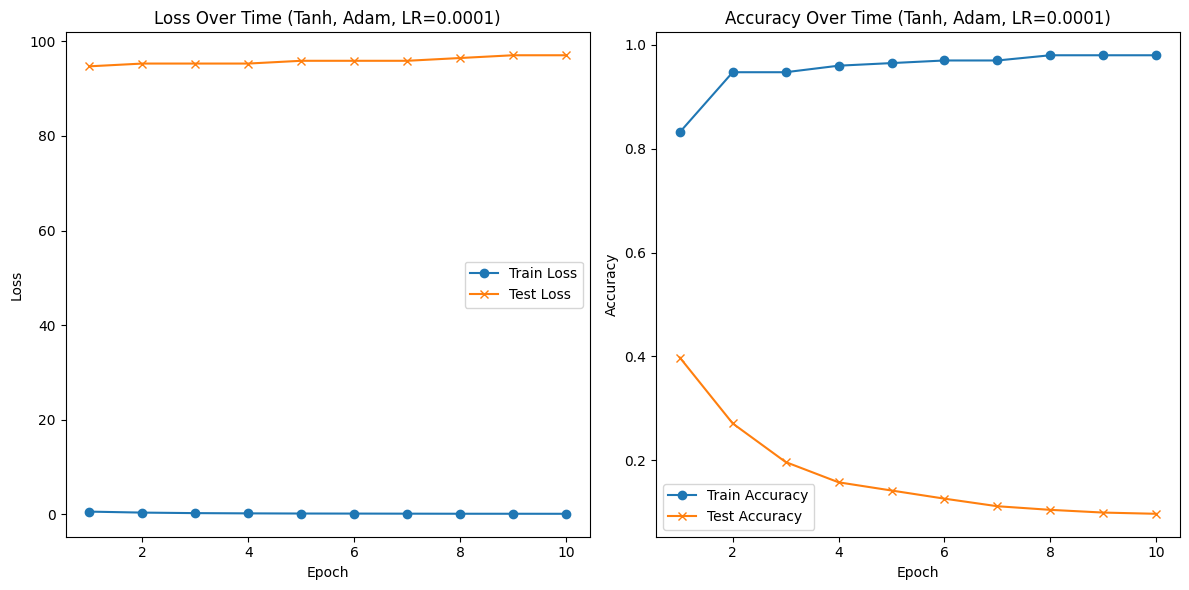

Training and testing completed!


accuracy,▅▅███▃▅▃▃▃█▅▅▁███▅▆▅▄▇▇█▂▄▄█▆█▅▅▅▅▆▆████
epoch,▅▇▁▆▃▃▇█▁▂▃█▃█▁▃▅█▂▃▆▂▆▇▆▃▅▆▇▂▃▃▃▁▂▃▄▆▄▆
loss,▇██▃▅▁▇▇▇▁▇▇▆▆▇████▇▇██▂▁▇▅▂▂████▂▇▂▂▆▅▆
test_accuracy,███▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_loss,▁▁▆▅▆██▃▃▃█████▆▆▆▆▆▃████▇▇▇▇███▃▄██████
train_accuracy,▁▁▅▅▅▅▅▅▅▅▆▆▇▇▇▇██▇▇
train_loss,██▆▆▅▅▄▄▃▃▃▃▂▂▂▂▁▁▁▁
accuracy,0.9799
epoch,9
loss,0.09228
test_accuracy,0.09674


In [252]:
import torch.optim as optim
import wandb

# Initialize W&B
wandb.init(project="breast-cancer-classification")

# Hyperparameters
config = {
    "epochs": 10,
    "learning_rate": 1e-3,
    "batch_size": 32,
    "optimizer": "SGD",  # or "Adam"
    "activation": "ReLU",  # or "Sigmoid", "Tanh"
    "hidden_units": 512
}
wandb.config.update(config)

# Select optimizer dynamically
def get_optimizer(optimizer_name, model, learning_rate):
    if optimizer_name == "SGD":
        return optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_name == "Adam":
        return optim.Adam(model.parameters(), lr=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer {optimizer_name}")
    
# Training loop with plotting


# Set up the training loop for different configurations
for activation in ["ReLU", "Sigmoid", "Tanh"]:
    for optimizer_name in ["SGD", "Adam"]:
        for lr in [1e-3, 1e-4]:
            for batch_size in [32, 64]:
                print(f"Running experiment with {activation}, {optimizer_name}, LR={lr}, Batch={batch_size}")
                
                # Update config in W&B
                wandb.config.update({
                    "activation": activation,
                    "optimizer": optimizer_name,
                    "learning_rate": lr,
                    "batch_size": batch_size
                })
                
                # Initialize model and optimizer
                model = NeuralNetwork(activation_function=activation).to(device)
                optimizer = get_optimizer(optimizer_name, model, lr)
                
                # Dataloader
                train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
                test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)
                
                train_losses = []
                train_accuracies = []
                test_losses = []
                test_accuracies = []
                
                # Train the model
                epochs_nr = wandb.config.epochs
                for epoch in range(epochs_nr):
                    avg_loss, avg_acc = train(train_dataloader, model, loss_fn, optimizer)
                    accuracy, test_loss = test(test_dataloader, model)
                    
                    # Collect data for plotting
                    train_losses.append(avg_loss)
                    train_accuracies.append(avg_acc)
                    test_losses.append(test_loss)
                    test_accuracies.append(accuracy)
                    
                    # Log metrics to W&B
                    wandb.log({
                        "epoch": epoch,
                        "loss": avg_loss,
                        "accuracy": avg_acc,
                        "test_accuracy": accuracy,
                        "test_loss": test_loss
                    })
                    
                # Plotting the results for this experiment
                plt.figure(figsize=(12, 6))

                # Plot the loss over time
                plt.subplot(1, 2, 1)
                plt.plot(range(1, epochs_nr + 1), train_losses, marker='o', label='Train Loss')
                plt.plot(range(1, epochs_nr + 1), test_losses, marker='x', label='Test Loss')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.title(f'Loss Over Time ({activation}, {optimizer_name}, LR={lr})')
                plt.legend()

                # Plot the accuracy over time
                plt.subplot(1, 2, 2)
                plt.plot(range(1, epochs_nr + 1), train_accuracies, marker='o', label='Train Accuracy')
                plt.plot(range(1, epochs_nr + 1), test_accuracies, marker='x', label='Test Accuracy')
                plt.xlabel('Epoch')
                plt.ylabel('Accuracy')
                plt.title(f'Accuracy Over Time ({activation}, {optimizer_name}, LR={lr})')
                plt.legend()

                # Show the plots
                plt.tight_layout()
                plt.show()

print("Training and testing completed!")
wandb.finish()